# Analysis of HST/STIS WASP-121b data
Author: Néstor Espinoza (nespinoza@stsci.edu) | Latest modification: March 31, 2021

## 1. Introduction

Let's first load some libraries:

In [1]:
import numpy as np
import pickle
import glob
import matplotlib.pyplot as plt
from numpy.polynomial import chebyshev
from scipy.signal import medfilt
from scipy.interpolate import UnivariateSpline

from astropy.io import fits

import juliet

/Users/nespinoza/.local/lib/python3.7/site-packages/autograd/numpy/numpy_wrapper.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  int_types = {_np.int, _np.int8, _np.int16, _np.int32, _np.int64, _np.integer}


Let's first organize the data in some human-readable form using the MAST data products. We'll extract the `*_flt.fits` products, and save them in dictionaries with the function below: 

In [2]:
def seek_and_not_destroy(datafolder):
    folders = glob.glob(datafolder+'/*')
    out = {}
    for folder in folders:
        # Extract data for the given folder/orbit:
        file = glob.glob(folder+'/*_flt.fits')[0]
        d = fits.open(file)
        
        # Extract date of start of the current orbit:
        date = d[0].header['TEXPSTRT'] + 2400000.5
        if date not in out.keys():
            out[date] = {}
            out[date]['day-start'] = d[0].header['TDATEOBS']
            out[date]['hour-start'] = d[0].header['TTIMEOBS']
            
        # Now retrieva spectra and metadata from each of the exposures of the current orbit.
        # To do this, we note each file has on d[0] the PRIMARY, and then three outputs per 
        # exposure --- d[1] is SCI for the first exposure, d[2] ERR and d[3] the DQ; then for the 
        # next exposure d[4] is SCI, d[5] ERR and d[6] is DQ, and so on --- so we count the number 
        # of exposures as (len(d)-1)/3 below:
        for exposure in range(1, int((len(d)-1)/3)*3, 3):
            data, data_header = d[exposure].data, d[exposure].header
            texposure = (data_header['EXPSTART'] + data_header['EXPEND']) * 0.5 + 2400000.5
            out[date][texposure] = {}
            out[date][texposure]['EXPSTART'] = data_header['EXPSTART'] + 2400000.5
            out[date][texposure]['EXPEND'] = data_header['EXPEND'] + 2400000.5
            out[date][texposure]['EXPTIME'] = data_header['EXPTIME']
            out[date][texposure]['WAV'] = data_header['CRVAL1'] + (np.arange(data.shape[1]) - \
                                          data_header['CRPIX1']) * data_header['CD1_1']
            out[date][texposure]['SPECTRA'] = np.copy(data)
            out[date][texposure]['SPECTRA_ERR'] = np.copy(d[exposure+1].data)
            out[date][texposure]['SPECTRA_DQ'] = np.copy(d[exposure+2].data)
    return out

With this, let's extract the data to a dictionary:

In [3]:
data = seek_and_not_destroy('data')

This dictionary now has every orbit in a key; **each key is the actual time of the start of that orbit**. Each orbit is, itself, a dictionary, where **each key of that sub-dictionary is the mid-time of an exposure in that orbit**; each of those has all the information on the spectrum for that exposure: `EXPSTART` (time of start of the exposure), `EXPEND` (time of end of that exposure), `EXPTIME` (the total exposure time), `WAV` (the wavelength at each pixel column), `SPECTRA` (the 2D spectrum), `SPECTRA_ERR` (the error on each point in this 2D spectrum) and `SPECTRA_DQ` (the data quality flags for each pixel in the 2D spectrum). 

All right, let's plot the first spectrum of the first orbit, just for fun:

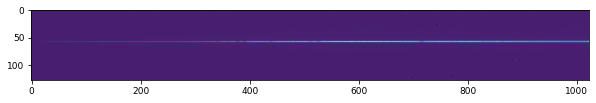

In [4]:
# Extract the time of start of every orbit:
orbit_times = np.array(list(data.keys()))

# Order them:
idx = np.argsort(orbit_times)
orbit_times = orbit_times[idx]

# Extract the times of the first orbit exposures; start from index 2 because first two indices 
# correspond to day/time of the orbit in string format:
firt_orbit_times = np.array(list(data[orbit_times[0]].keys())[2:])

# Plot spectrum of first exposure of first orbit:
plt.figure(figsize=(10,5))
im = plt.imshow(data[orbit_times[0]][firt_orbit_times[0]]['SPECTRA'])

All right, let's plot the data phased to the orbital period! For WASP-121b, the orbital period is `1.2749255` days and time-of-transit center is `2456635.70832`. Let's do a simple sum of all the rows between 50 and 70 (based on the plot above) to get the flux of the entire spectrum:

Text(0, 0.5, 'Relative flux')

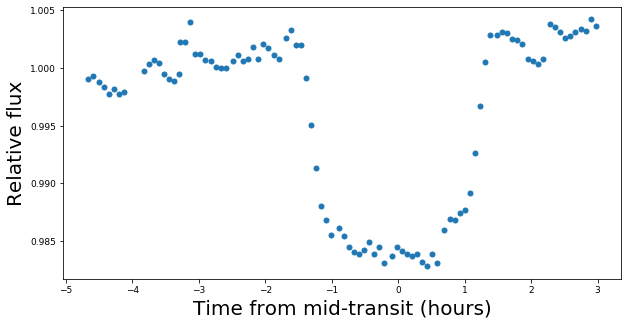

In [5]:
times = np.array([])
fluxes = np.array([])

for orbit_time in orbit_times:
    exposure_times = np.array(list(data[orbit_time].keys())[2:])
    for exposure_time in exposure_times:
        times = np.append(times, exposure_time)
        fluxes = np.append(fluxes, np.sum(data[orbit_time][exposure_time]['SPECTRA'][50:70,:]))

t0, P = 2456635.70832, 1.2749255
phases = juliet.utils.get_phases(times, P, t0)

# Plot
plt.figure(figsize=(10,5))
plt.plot(phases*P*24, fluxes/np.median(fluxes), 'o')
plt.xlabel('Time from mid-transit (hours)', fontsize=20)
plt.ylabel('Relative flux',fontsize=20)

Nice --- transit is there! Let's now jump into a "better" data analysis for this dataset.

All right, that looks mostly okay! Let's jump to cosmic ray rejection, and then spectral extraction.

### 2.1 Cosmic-ray correction

The tracing and extraction steps would be straightforward if it weren't for bad pixels and cosmic rays. Let's try to do some quick corrections on those first; to this end, let's just study the time-series of pixels on all exposures for a given orbit; any outlier pixel can be flagged if it's too different from the rest. Let's look at the first orbit to do a check on how this method would work:

In [6]:
first_orbit = data[orbit_times[0]]
frames = list(first_orbit.keys())[2:]

Let's look at the first frame:

(150, 180)

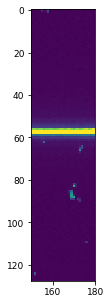

In [7]:
plt.figure(figsize=(20,5))
im = plt.imshow(first_orbit[frames[0]]['SPECTRA'])
im.set_clim(-10,1000)
plt.xlim(150, 180)

So, column 170 seems to have an outlier:

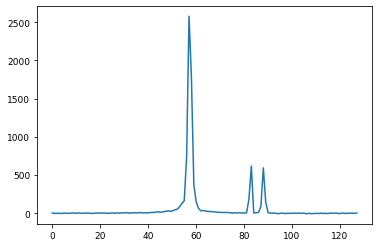

In [8]:
plt.plot(first_orbit[frames[0]]['SPECTRA'][:, 170])

Let's see if it appears in the other exposures:

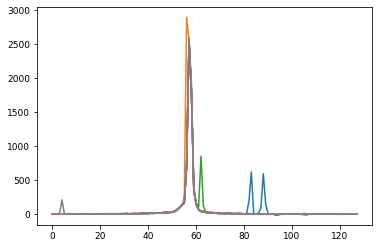

In [9]:
for frame in frames:
    plt.plot(first_orbit[frame]['SPECTRA'][:, 170])

A close-up:

(80, 90)

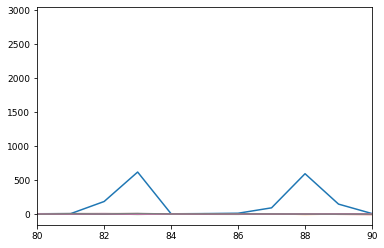

In [10]:
for frame in frames:
    plt.plot(first_orbit[frame]['SPECTRA'][:, 170])
plt.xlim(80,90)

It does not! So here's what I propose we do --- we simply plot the time-series of each pixel, and perform identification by 5-sigma differences. So, for instance, this particular outlier ocurrs at pixel 83. Let's look at the time series of that pixel in all frames:

<ErrorbarContainer object of 3 artists>

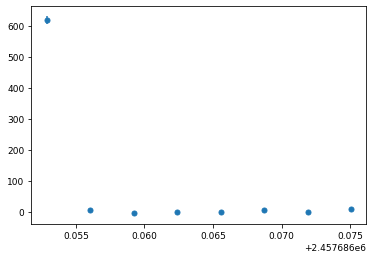

In [11]:
times = np.array([])
fluxes = np.array([])
fluxes_err = np.array([])
for frame in frames:
    times = np.append(times, frame)
    fluxes = np.append(fluxes, first_orbit[frame]['SPECTRA'][83, 170])
    fluxes_err = np.append(fluxes_err, first_orbit[frame]['SPECTRA_ERR'][83, 170])
plt.errorbar(times, fluxes, fluxes_err, fmt='o')

The outlier flux is clear as day. If we do a close-up to the other fluxes:

(-20, 20)

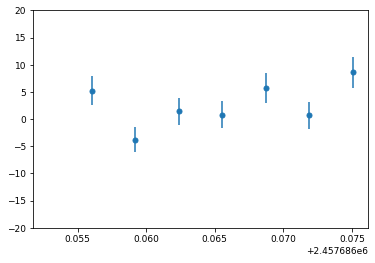

In [12]:
plt.errorbar(times, fluxes, fluxes_err, fmt='o')
plt.ylim(-20,20)

They are all consistent! Nice. In the plot above there is also something happening (which is apparently normal) on the profile at around pixel 55:

(50, 60)

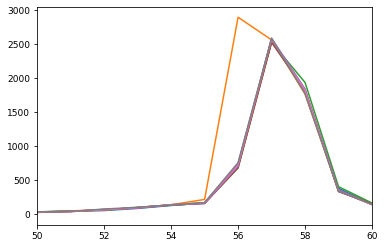

In [13]:
for frame in frames:
    plt.plot(first_orbit[frame]['SPECTRA'][:, 170])
plt.xlim(50,60)

So --- is this an outlier as well? Let's see:

<ErrorbarContainer object of 3 artists>

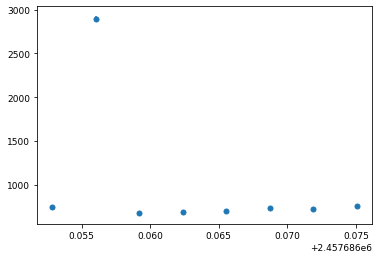

In [14]:
times = np.array([])
fluxes = np.array([])
fluxes_err = np.array([])
for frame in frames:
    times = np.append(times, frame)
    fluxes = np.append(fluxes, first_orbit[frame]['SPECTRA'][56, 170])
    fluxes_err = np.append(fluxes_err, first_orbit[frame]['SPECTRA_ERR'][56, 170])
plt.errorbar(times, fluxes, fluxes_err, fmt='o')

It seems so! Is this visible in the actual data?

(50, 65)

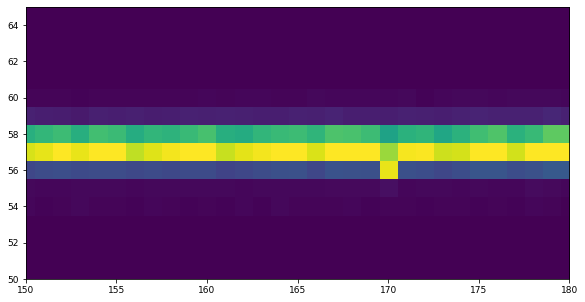

In [15]:
plt.figure(figsize=(20,5))
im = plt.imshow(first_orbit[frames[1]]['SPECTRA'])
im.set_clim(100,3000)
plt.xlim(150, 180)
plt.ylim(50,65)

Yes it is! Nice. Okay, so --- what do we do with these fluxes? First, identify them by comparing their fluxes again the median fluxes. If they are off, create a bad pixel mask. Then, scale pixels on the same row before and after to know the flux of the bad pixel. Let's save the results on the same dictionary on the `CSPECTRA` and `CSPECTRA_ERR` keys. This takes a while (like a couple of minutes in my computer):

In [18]:
nsigma_cr = 5
first_spectrum = data[orbit_times[0]][firt_orbit_times[0]]['SPECTRA']

for orbit_time in orbit_times:
    
    # Extract exposure times:
    exposure_times = np.array(list(data[orbit_time].keys())[2:])
    nexposures = len(exposure_times)
    
    # Copy original and error spectra (here we'll save the corrected exposures):
    for i in range(nexposures):
        # Copy corrected spectrum (and corrected error):
        data[orbit_time][exposure_times[i]]['CSPECTRA'] = np.copy(data[orbit_time][exposure_times[i]]['SPECTRA'])
        data[orbit_time][exposure_times[i]]['CSPECTRA_ERR'] = np.copy(data[orbit_time][exposure_times[i]]['SPECTRA_ERR'])
        data[orbit_time][exposure_times[i]]['BADPIXELMASK'] = np.zeros(data[orbit_time][exposure_times[i]]['SPECTRA'].shape)
    
    # Iterate through the pixels
    for row in range(first_spectrum.shape[0]):
        # Iterate only through columns were centroiding is available:
        for column in range(first_spectrum.shape[1]):
            
            # Now gather the fluxes:
            fluxes = np.zeros(nexposures)
            fluxes_err = np.zeros(nexposures)
            
            for i in range(nexposures):
                fluxes[i] = data[orbit_time][exposure_times[i]]['SPECTRA'][row, column]
                fluxes_err[i] = data[orbit_time][exposure_times[i]]['SPECTRA_ERR'][row, column]
                
            # Calculate median flux and median error:
            median_fluxes = np.median(fluxes)
            median_fluxes_err = np.median(fluxes_err)
            
            # Identify pixels nsigma_cr away from this:
            idx = np.where(np.abs(median_fluxes - fluxes)/fluxes_err > nsigma_cr)[0]
            
            # Create bad pixel mask:
            for i in idx:
                data[orbit_time][exposure_times[i]]['BADPIXELMASK'][row, column] = 1
                
    # Now iterate again to correct fluxes on the given orbit:
    for row in range(first_spectrum.shape[0]):
        # Iterate only through columns were centroiding is available:
        for column in range(first_spectrum.shape[1]):
            for i in range(nexposures):
                # If bad pixel mask says so, correct it:
                if data[orbit_time][exposure_times[i]]['BADPIXELMASK'][row, column] == 1:
                    if i != 0:
                        c_spec = np.copy(data[orbit_time][exposure_times[i-1]]['SPECTRA'])
                        c_spec_err = np.copy(data[orbit_time][exposure_times[i-1]]['SPECTRA_ERR'])
                    else:
                        c_spec = np.copy(data[orbit_time][exposure_times[i+1]]['SPECTRA'])
                        c_spec_err = np.copy(data[orbit_time][exposure_times[i+1]]['SPECTRA_ERR'])
                        
                    # Check column to the side of the target, or the two right-most or left-most 
                    # if on the edges:
                    if column > 2 and column < c_spec.shape[1]-3:
                        frac = np.median(data[orbit_time][exposure_times[i]]['SPECTRA'][row, column-3:column+3] / \
                               c_spec[row, column-3:column+3])
                    elif column == 0:
                        frac = np.median(data[orbit_time][exposure_times[i]]['SPECTRA'][row, :5] / \
                                         c_spec[row, :5])
                    elif column != c_spec.shape[1]:
                        frac = np.median(data[orbit_time][exposure_times[i]]['SPECTRA'][row, -5:] / \
                                         c_spec[row, -5:])
                    
                    data[orbit_time][exposure_times[i]]['CSPECTRA'][row, column] = frac * c_spec[row, column]
                    data[orbit_time][exposure_times[i]]['CSPECTRA_ERR'][row, column] = c_spec_err[row, column]


Let's see how we did on the outliers we identified by eye above:

In [19]:
corrected_first_orbit = data[orbit_times[0]]

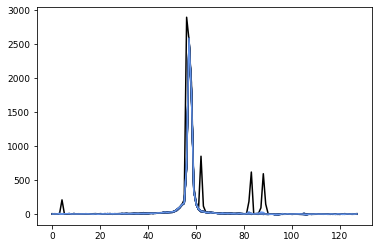

In [20]:
for frame in frames:
    plt.plot(corrected_first_orbit[frame]['SPECTRA'][:, 170], color='black')
    plt.plot(corrected_first_orbit[frame]['CSPECTRA'][:, 170], color='cornflowerblue')

Nice! Let's plot an actual spectral image comparison:

(150, 300)

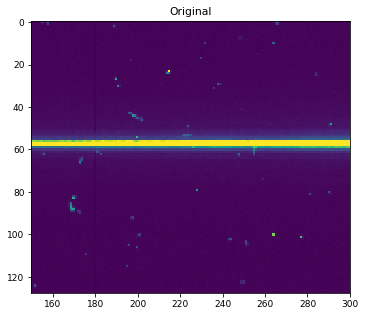

In [21]:
plt.figure(figsize=(20,5))
plt.title('Original')
im = plt.imshow(first_orbit[frames[0]]['SPECTRA'])
im.set_clim(-10,1000)
plt.xlim(150, 300)

(150, 300)

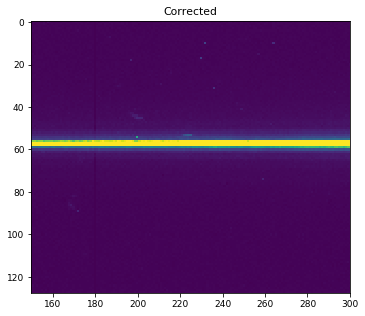

In [22]:
plt.figure(figsize=(20,5))
plt.title('Corrected')
im = plt.imshow(corrected_first_orbit[frames[0]]['CSPECTRA'])
im.set_clim(-10,1000)
plt.xlim(150, 300)

Excellent job! Let's save this dictionary so we save our progress up to now.

In [23]:
filehandler = open("cc_corrected.pkl","wb")
pickle.dump(data,filehandler)
filehandler.close()

Let's jump to tracing and spectral extraction now.

## 2.2 Tracing

### 2.1.1 First steps
All right, let's trace the spectrum. Let's get an idea of the trace shape first --- let's plot a cut in a column on the data plotted above:

dict_keys([2457698.89126346, 2457686.3075361, 2457699.0899905, 2457686.10889018, 2457699.0237405, 2457686.17510536, 2457698.83524494, 2457686.05140166, 2457698.95750198, 2457686.24132092])


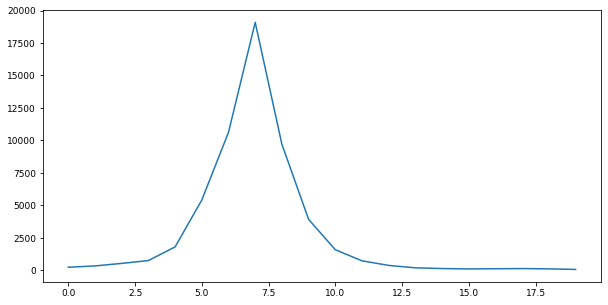

In [24]:
# Read data pickle if starting from here:
try:
    print(data.keys())
except:
    data = pickle.load(open('cc_corrected','rb'))

first_spectrum = data[orbit_times[0]][firt_orbit_times[0]]['CSPECTRA']

# Plot
plt.figure(figsize=(10,5))
plt.plot(first_spectrum[50:70,first_spectrum.shape[1]-1])

All right, it seems simple centroiding would do a decent job. I wrote a function to do this below:

In [25]:
def trace_spectrum(image, xstart, ystart, profile_radius = 20, xend = None):
    """
    Function that non-parametrically traces HST/STIS spectra. First, to get the centroid at xstart and 
    ystart, it convolves the spatial profile with a gaussian filter, finding its peak through usual flux-weighted 
    centroiding. Next, it uses a smoothed shape in this column to find the centroid of the next, left column, 
    through cross-correlation of that shape.
    
    Parameters
    ----------
    image: ndarray
        The image that wants to be traced.
    xstart: float
        The x-position (column) on which the tracing algorithm will be started
    ystart: float
        The estimated y-position (row) of the center of the trace. An estimate within 10-20 pixels is enough.
    profile_radius: float
        Expected radius of the profile measured from its center. Only this region will be used to estimate 
        the centroids of the spectrum.=
    xend: int
        x-position at which tracing ends. If none, trace all the columns left to xstart.
        
    Returns
    -------
    x : np.array
        Columns at which centroids are calculated
    y : np.array
        Centroids at a given column
    """
    # Define x-axis:
    if xend is not None:
        x = np.arange(xend,xstart)
    else:
        x = np.arange(0,xstart)
    # Define y-axis:
    y = np.arange(image.shape[0])
    # Define array that will save centroids at each x:
    ycentroids = np.zeros(len(x))
    for i in range(len(x))[::-1]:
        xcurrent = x[i]
        # Remove background variations through a median of the entire column:
        filtered_column = image[:,xcurrent] - np.median(image[:,xcurrent])
        # Find centroid within profile_radius pixels of the initial guess:
        idx = np.where(np.abs(y-ystart)<profile_radius)[0]
        ycentroids[i] = np.sum(y[idx]*filtered_column[idx])/np.sum(filtered_column[idx])
        ystart = ycentroids[i]
    # Check for nans:
    idx = np.where(~np.isnan(ycentroids))
    return x[idx],ycentroids[idx]

Let's try this on this first spectrum first to check how the algorithm does. We choose `xstart` as the most right-most column. For `ystart`, we choose row 57 --- which seems to be close to the value according to our plot of the profile above. For `profile_radius` we use a value of `15` which is large enough to capture the entire central profile:

In [26]:
xstart, ystart, profile_radius = first_spectrum.shape[1], 57, 15
x, y = trace_spectrum(first_spectrum, xstart, ystart, profile_radius = profile_radius)

Let's see how we did:

(40, 80)

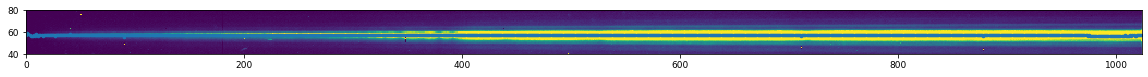

In [27]:
plt.figure(figsize=(20,5))

# Plot image:
im = plt.imshow(first_spectrum)
im.set_clim(0,500)

# Plot centroids:
plt.plot(x,y,'.')

plt.ylim(40,80)

(56.5, 57.6)

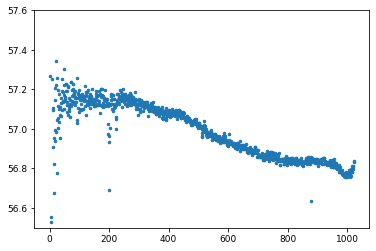

In [28]:
plt.plot(x,y,'.')
plt.ylim(56.5,57.6)

That's pretty good! I wonder what happened at about column 1000 --- it seems there is a weird change there? Close-up to the image:

(900, 1024)

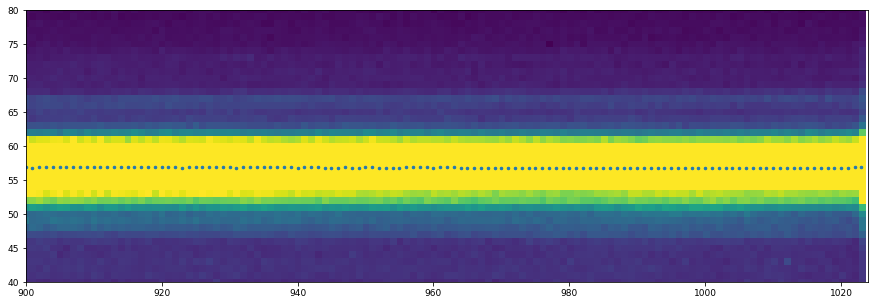

In [29]:
plt.figure(figsize=(20,5))

# Plot image:
im = plt.imshow(first_spectrum)
im.set_clim(0,500)

# Plot centroids:
plt.plot(x,y,'.')

plt.ylim(40,80)
plt.xlim(900, first_spectrum.shape[1])

(900, 1024)

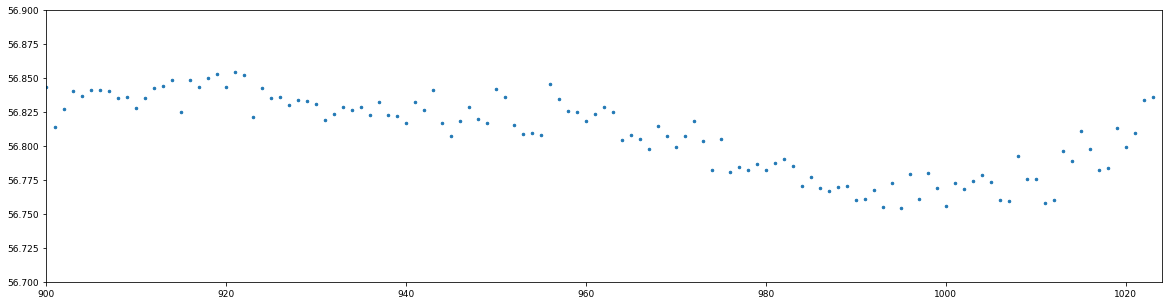

In [30]:
plt.figure(figsize=(20,5))
plt.plot(x,y,'.')
plt.ylim(56.7,56.9)
plt.xlim(900, first_spectrum.shape[1])

Right --- it seems the decrease is "real", and is just because the very last column's profile is just wider for some reason. Well, though luck :-). All right, let's now fit this profile with a Chebyshev polynomial. Let's select the order using the BIC:

Best order: 19


(56.5, 57.6)

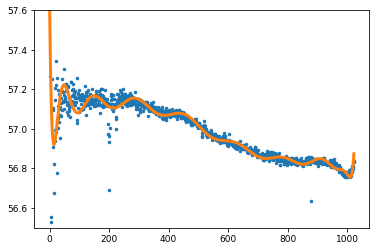

In [31]:
def select_cheby_order(x,y,min_order,max_order):
    """
    This function selects (and returns) the optimal order of a Chebyshev polynomial using the BIC.
    
    Parameters
    ----------
    x: ndarray
        Array with the regressors
    y: ndarray
        Array with the data
    min_order: int
        Minimum order to try
    max_order: int
        Maximum order to try
    """
    orders = np.arange(min_order,max_order)
    bics = np.zeros(len(orders))
    n = len(x)
    for i in range(len(orders)):
        order = orders[i]
        coeffs = chebyshev.chebfit(x,y,deg=order)
        RSS = np.sum((y - chebyshev.chebval(x,coeffs))**2)
        bics[i] = n*np.log(RSS/n) + (order+1)*np.log(n)
    idx = np.where(np.min(bics) == bics)[0]
    return orders[idx][0]

# Try all orders from 1 to 30:
best_order = select_cheby_order(x, y, 1, 30)
print('Best order:', best_order)

# Let's see how that fit does:
coeffs = chebyshev.chebfit(x, y, deg = best_order)
plt.plot(x, y, '.')
plt.plot(x, chebyshev.chebval(x, coeffs), lw=3)
plt.ylim(56.5,57.6)

Hmmm --- I fear the outliers might be throwing the fit off. Let's do a median filter to see if it follows the profile more or less okay:

(56.5, 57.6)

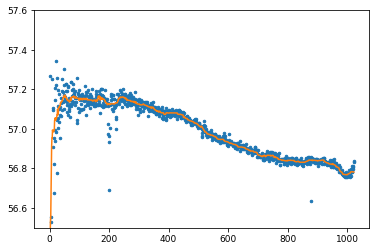

In [32]:
mfilt = medfilt(y,21)
plt.plot(x,y,'.')
plt.plot(x,mfilt,'-')
plt.ylim(56.5,57.6)

All right, that's seems okay, although it doesn't seem like it caught _a ton_ of outliers. Let's write a function that performs some outlier rejection. Let's be pretty aggresive with the rejection --- trace really should be smooth:

In [33]:
def remove_outliers(x, y, nsigma = 3):
    mfilt = medfilt(y,21)
    sigma = get_mad_sigma(y - mfilt)
    idx = np.where(np.abs(y - mfilt) < nsigma*sigma)[0]
    return x[idx], y[idx]
    
def get_mad_sigma(x):
    """ MAD-to-sigma conversion comes from: https://en.wikipedia.org/wiki/Median_absolute_deviation """
    mad = np.median(np.abs(x - np.median(x)))
    return mad*1.4826

(56.5, 57.6)

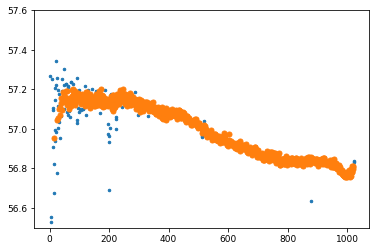

In [34]:
new_x, new_y = remove_outliers(x, y)
plt.plot(x,y,'.')
plt.plot(new_x, new_y,'o')
plt.ylim(56.5,57.6)

What if we do it a second time?

(56.5, 57.6)

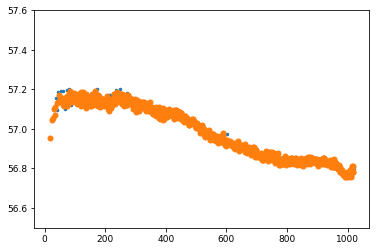

In [35]:
plt.plot(new_x,new_y,'.')
new_x, new_y = remove_outliers(new_x, new_y)
plt.plot(new_x, new_y,'o')
plt.ylim(56.5,57.6)

Yeah, not really needed here --- but no damage either. Might be useful in other traces, so might be a good idea. Does the fit improve with this outlier rejection scheme?

Best order: 16


(56.5, 57.6)

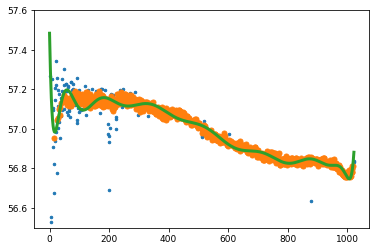

In [36]:
# Try all orders from 1 to 30 on outlier-corrected data:
best_order = select_cheby_order(new_x, new_y, 1, 30)
print('Best order:', best_order)

# Let's see how that fit does:
coeffs = chebyshev.chebfit(x, y, deg = best_order)
plt.plot(x, y, '.')
plt.plot(new_x, new_y,'o')
plt.plot(x, chebyshev.chebval(x, coeffs), lw=3)
plt.ylim(56.5,57.6)

All right, that's pretty bad. What about using a spline?

(56.5, 57.6)

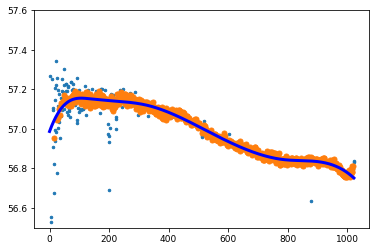

In [37]:
spl = UnivariateSpline(new_x, new_y)
spl.set_smoothing_factor(0.25)

# Let's see how that fit does:
plt.plot(x, y, '.')
plt.plot(new_x, new_y,'o')
plt.plot(x, spl(x), 'b', lw=3)
plt.ylim(56.5,57.6)

All right, that's much better. We need to select the smoothing factor. Let's do a simple grid search via cross-validation; we do $K$-fold CV with $K=10$:

In [38]:
smoothing_factors = np.linspace(0.,1.,100)
cv_errors = np.zeros(len(smoothing_factors))
K = 10

# Create the folds:
folds = []
fold_length = int(len(new_y)/K)
for i in range(0, len(new_y), fold_length):
    if (i + fold_length) < len(new_y): 
        folds.append(np.arange(i, i + fold_length))
N_folds = len(folds)

# And now perform CV with each of the to-be-tested smoothing factors:
for i in range(len(smoothing_factors)):
    cv_error = np.array([])
    for fold in folds:
        validation_fold = np.array([True]*len(new_y))
        test_fold = np.array([False]*len(new_y))
        validation_fold[fold] = False
        test_fold[fold] = True
        spl = UnivariateSpline(new_x[validation_fold], new_y[validation_fold])
        spl.set_smoothing_factor(smoothing_factors[i])
        cv_error = np.append(cv_error, np.sum(np.abs(spl(new_x[test_fold]) - new_y[test_fold])))
    cv_errors[i] = np.mean(cv_error)

Text(0, 0.5, 'Residuals')

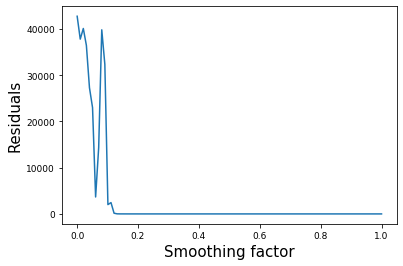

In [39]:
plt.plot(smoothing_factors, cv_errors)
plt.xlabel('Smoothing factor', fontsize = 15)
plt.ylabel('Residuals', fontsize = 15)

And the winner smoothing factor is:

In [40]:
idx = np.where(cv_errors == np.min(cv_errors))[0]
best_sf = smoothing_factors[idx][0]
print(best_sf)

0.22222222222222224


Let's see how it looks like:

(56.5, 57.6)

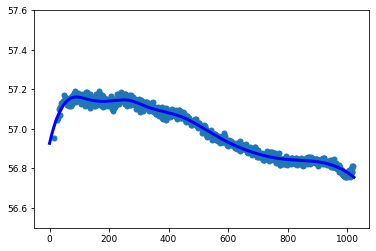

In [41]:
spl = UnivariateSpline(new_x, new_y)
spl.set_smoothing_factor(best_sf)

# Let's see how that fit does:
plt.plot(new_x, new_y,'o')
plt.plot(x, spl(x), 'b', lw=3)
plt.ylim(56.5,57.6)

That's decent on the mid wavelengths; poor job on the edges, but that's OK.  

#### 2.1.2 All together now

So, we repeat the following tracing procedure for the rest of our images:

1. Trace with our centroiding algorithm.
2. Use a median filter to find outliers.
3. Fit a spline to the outlier-corrected centroids.
4. Evaluate the spline as our best guess for the centroids (which will be used for spectral extraction).

Let's see how we do, iterating through all the data --- we save the results on the dictionary itself:

Minimum and maximum columns extractable columns: 33 and 1016


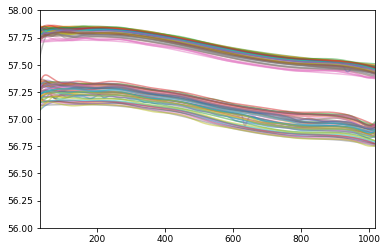

In [42]:
# Check the minimum common column without outliers; do the same for the maximum column:
min_x, max_x = 0, first_spectrum.shape[1]

for orbit_time in orbit_times:
    exposure_times = np.array(list(data[orbit_time].keys())[2:])
    for exposure_time in exposure_times:
        
        # Get 2D spectrum:
        spectrum = data[orbit_time][exposure_time]['CSPECTRA']
        
        # Trace it:
        x, y = trace_spectrum(spectrum, xstart, ystart, profile_radius = profile_radius)
        
        # Find outliers:
        new_x, new_y = remove_outliers(x, y)
        
        # Run a second time:
        new_x, new_y = remove_outliers(new_x, new_y)
        
        # Get spline fit:
        spl = UnivariateSpline(new_x, new_y)
        spl.set_smoothing_factor(best_sf)
        
        # Evaluate spline on all centroids:
        cmin, cmax = np.min(new_x), np.max(new_x)
        data[orbit_time][exposure_time]['xcentroids'] = np.arange(cmin, cmax)
        data[orbit_time][exposure_time]['ycentroids'] = spl(data[orbit_time][exposure_time]['xcentroids'])
        plt.plot(data[orbit_time][exposure_time]['xcentroids'], \
                 data[orbit_time][exposure_time]['ycentroids'], alpha = 0.5)
        
        # Check min_x and max_x:
        if cmin > min_x:
            min_x = cmin
            
        if cmax < max_x:
            max_x = cmax
            
plt.ylim(56, 58)
plt.xlim(min_x, max_x)
print('Minimum and maximum columns extractable columns:',min_x, 'and',max_x)

# Save those columns to the pickle file:
for orbit_time in orbit_times:
    exposure_times = np.array(list(data[orbit_time].keys())[2:])
    for exposure_time in exposure_times:
        data[orbit_time][exposure_time]['min_x'] = min_x
        data[orbit_time][exposure_time]['max_x'] = max_x

Let's save results up to now:

In [43]:
filehandler = open("cc_corrected_and_traced.pkl","wb")
pickle.dump(data,filehandler)
filehandler.close()

## 2.3 Spectral extraction

All right, let's jump to spectral extraction. Let's load the data in case we stopped working and closed the session before this:



In [44]:
try:
    print(data.keys())
except:
    data = pickle.load(open('cc_corrected_and_traced.pkl','rb'))

dict_keys([2457698.89126346, 2457686.3075361, 2457699.0899905, 2457686.10889018, 2457699.0237405, 2457686.17510536, 2457698.83524494, 2457686.05140166, 2457698.95750198, 2457686.24132092])


All right, so here is a function to perform spectral extraction given a spectra and error matrix. We'll extract all the spectra from column 34 to 1017, and extract spectra with an aperture of 10 pixels:

In [45]:
def aperture_extraction(image, x, y, aperture_radius, background_radius=50, error_image=None, correct_bkg=True):
    """
    This function takes as inputs two arrays (x,y) that follow the trace, 
    and returns the added flux over the defined aperture radius (and its error, if an error image 
    is given as well), substracting in the way any background between the aperture radius and the 
    background radius. The background is calculated by taking the median of the points between the 
    aperture_radius and the background_radius.
    Parameters
    ----------
    image: ndarray
        Image from which the spectrum wants to be extracted
    x: ndarray
        Array with the x-axis of the trace (i.e., the columns, wavelength direction)
    y: ndarray
        Array with the y-axis of the trace (i.e., rows, spatial direction)
    aperture_radius: float
        Distance from the center of the trace at which you want to add fluxes.
    background_radius: float
        Distance from the center of the trace from which you want to calculate the background. The 
        background region will be between this radius and the aperture_radius.
    error_image: ndarray
        Image with the errors of each pixel value on the image ndarray above
    correct_bkg: boolean
        If True, apply background correction. If false, ommit this.
    """
    # Create array that will save our fluxes:
    flux = np.zeros(len(x))
    if error_image is not None:
        flux_error = np.zeros(len(x))
    max_column = image.shape[0]
    for i in range(len(x)):
        # Cut the column with which we'll be working with:
        column = image[:,int(x[i])]
        if error_image is not None:
            variance_column = error_image[:,int(x[i])]**2
        # Define limits given by the aperture_radius and background_radius variables:
        if correct_bkg:
            left_side_bkg = np.max([y[i] - background_radius, 0])
            right_side_bkg = np.min([max_column, y[i] + background_radius])
        left_side_ap = np.max([y[i] - aperture_radius, 0])
        right_side_ap = np.min([max_column, y[i] + aperture_radius])
        # Extract background, being careful with edges:
        if correct_bkg:
            bkg_left = column[np.max([0, int(left_side_bkg)]) : np.max([0, int(left_side_ap)])]
            bkg_right = column[np.min([int(right_side_ap), max_column]) : np.max([int(right_side_bkg), max_column])]
            bkg = np.median(np.append(bkg_left, bkg_right))
        else:
            bkg = 0.
        # Substract it from the column:
        column -= bkg
        # Perform aperture extraction of the background-substracted column, being careful with pixelization 
        # at the edges. First, deal with left (up) side:
        l_decimal, l_integer = np.modf(left_side_ap)
        l_integer = int(l_integer)
        if l_decimal < 0.5:
            l_fraction = (0.5 - l_decimal) * column[l_integer]
            l_limit = l_integer + 1
            if error_image is not None:
                l_fraction_variance = ((0.5 - l_decimal)**2) * variance_column[l_integer]
        else:
            l_fraction = (1. - (l_decimal - 0.5)) * column[l_integer + 1]
            l_limit = l_integer + 2
            if error_image is not None:
                l_fraction_variance = ((1. - (l_decimal - 0.5))**2) * variance_column[l_integer + 1]
        # Now right (down) side:
        r_decimal, r_integer = np.modf(right_side_ap)
        r_integer = int(r_integer)
        if r_decimal < 0.5:
            r_fraction = (1. - (0.5 - r_decimal)) * column[r_integer]
            r_limit = r_integer
            if error_image is not None:
                r_fraction_variance = ((1. - (0.5 - r_decimal))**2) * variance_column[r_integer]
        else:
            r_fraction = (r_decimal - 0.5) * column[r_integer + 1]
            r_limit = r_integer + 1
            if error_image is not None:
                r_fraction_variance = ((r_decimal - 0.5)**2) * variance_column[r_integer + 1]
        # Save total flux in current column:
        flux[i] = l_fraction + r_fraction + np.sum(column[l_limit:r_limit])
        if error_image is not None:
            # Total error is the sum of the variances:
            flux_error[i] = np.sqrt(np.sum(variance_column[l_limit:r_limit]) + l_fraction_variance + \
                                    r_fraction_variance)
    if error_image is not None:
        return flux, flux_error
    else:
        return flux

Let's iterate and extract the spectra (this might take a while --- like 10 secs on my laptop):

In [46]:
for orbit_time in orbit_times:
    exposure_times = np.array(list(data[orbit_time].keys())[2:])
    for exposure_time in exposure_times:
        
        min_x, max_x = data[orbit_time][exposure_time]['min_x'], data[orbit_time][exposure_time]['max_x']
        
        # Get 2D spectrum and error from corrected spectra:
        spectrum = data[orbit_time][exposure_time]['CSPECTRA']
        spectrum_err = data[orbit_time][exposure_time]['CSPECTRA_ERR']
        
        # Get centroids:
        x = data[orbit_time][exposure_time]['xcentroids']
        y = data[orbit_time][exposure_time]['ycentroids']
        
        # Lock centroids to the min_x and max_x
        idx = np.where((x > min_x) & (x < max_x))[0]
        
        # Extract spectra:
        data[orbit_time][exposure_time]['ESPECTRUM'], data[orbit_time][exposure_time]['ESPECTRUM_ERR'] = \
        aperture_extraction(spectrum, x[idx], y[idx], 8.5, background_radius=30, error_image=spectrum_err)
        
        # Extract uncorrected spectra:
        data[orbit_time][exposure_time]['NC_ESPECTRUM'], data[orbit_time][exposure_time]['NC_ESPECTRUM_ERR'] = \
        aperture_extraction(data[orbit_time][exposure_time]['SPECTRA'], x[idx], y[idx], 8.5, background_radius=30, \
                            error_image=data[orbit_time][exposure_time]['SPECTRA_ERR'])
        
        # Set extracted wavelength range:
        xwav = np.arange(len(data[orbit_time][exposure_time]['WAV']))
        idx = np.where((xwav > min_x) & (xwav < max_x))[0]
        data[orbit_time][exposure_time]['EWAV'] = data[orbit_time][exposure_time]['WAV'][idx]

Let's check the extracted spectra corrected versus non-corrected for cosmic-rays of a frame:

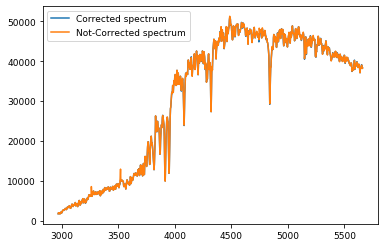

In [47]:
plt.plot(data[orbit_time][exposure_time]['EWAV'], data[orbit_time][exposure_time]['ESPECTRUM'], \
         label = 'Corrected spectrum')

plt.plot(data[orbit_time][exposure_time]['EWAV'], data[orbit_time][exposure_time]['NC_ESPECTRUM'], \
         label = 'Not-Corrected spectrum')

plt.legend()

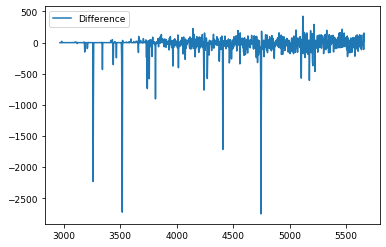

In [48]:
plt.plot(data[orbit_time][exposure_time]['EWAV'], \
         data[orbit_time][exposure_time]['ESPECTRUM']-data[orbit_time][exposure_time]['NC_ESPECTRUM'], \
         label = 'Difference')

plt.legend()

That looks nice. Do the errorbars make sense?

(3000, 3020)

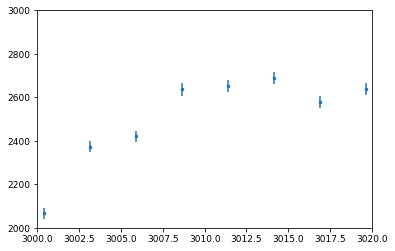

In [49]:
plt.errorbar(data[orbit_time][exposure_time]['EWAV'], data[orbit_time][exposure_time]['ESPECTRUM'], \
             data[orbit_time][exposure_time]['ESPECTRUM_ERR'], fmt='.')

plt.ylim(2000,3000)
plt.xlim(3000,3020)

That looks fine actually. Let's save our progress:

In [50]:
filehandler = open("extracted_spectra.pkl","wb")
pickle.dump(data,filehandler)
filehandler.close()

## 3. Lightcurve modelling

All right; let's try to plot the same lightcurves we plotted in the intro --- shall we? First, let's see if we already saved some progress and are starting from this section:

In [51]:
try:
    print(data.keys())
except:
    data = pickle.load(open('extracted_spectra.pkl','rb'))

dict_keys([2457698.89126346, 2457686.3075361, 2457699.0899905, 2457686.10889018, 2457699.0237405, 2457686.17510536, 2457698.83524494, 2457686.05140166, 2457698.95750198, 2457686.24132092])


Text(0, 0.5, 'Relative flux')

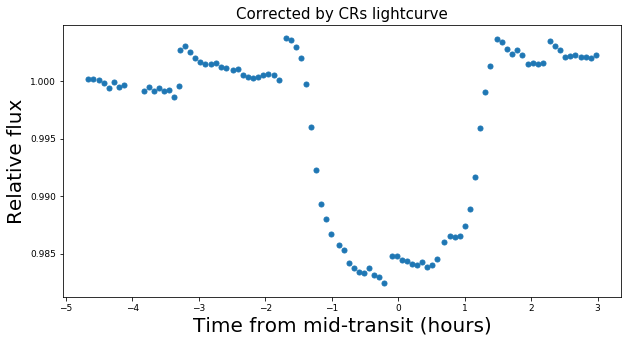

In [52]:
times = np.array([])
fluxes = np.array([])
fluxes_err = np.array([])

for orbit_time in orbit_times:
    exposure_times = np.array(list(data[orbit_time].keys())[2:])
    for exposure_time in exposure_times:
        times = np.append(times, exposure_time)
        idx = np.where(data[orbit_time][exposure_time]['EWAV']>3500)[0]
        fluxes = np.append(fluxes, np.sum(data[orbit_time][exposure_time]['ESPECTRUM'][idx]))
        fluxes_err = np.append(fluxes_err, \
                               np.sqrt(np.sum(data[orbit_time][exposure_time]['ESPECTRUM_ERR'][idx]**2)))

t0, P = 2456635.70832, 1.2749255
phases = juliet.utils.get_phases(times, P, t0)

# Plot
plt.figure(figsize=(10,5))
plt.title('Corrected by CRs lightcurve', fontsize=15)
plt.errorbar(phases*P*24, fluxes/np.median(fluxes), fluxes_err/np.median(fluxes), fmt= 'o')
plt.xlabel('Time from mid-transit (hours)', fontsize=20)
plt.ylabel('Relative flux',fontsize=20)

Hey, that looks pretty nice. Let's compare the uncorrected-by-cosmic-rays and the corrected-by-cosmic rays lightcurves:

Text(0, 0.5, 'Relative flux')

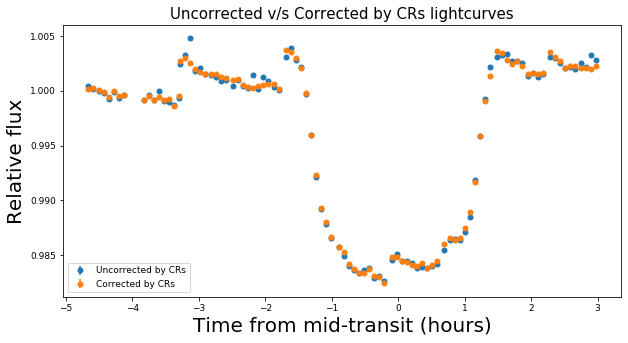

In [53]:
times_nc = np.array([])
fluxes_nc = np.array([])
fluxes_err_nc = np.array([])

for orbit_time in orbit_times:
    exposure_times = np.array(list(data[orbit_time].keys())[2:])
    for exposure_time in exposure_times:
        times_nc = np.append(times_nc, exposure_time)
        idx = np.where(data[orbit_time][exposure_time]['EWAV']>3500)[0]
        fluxes_nc = np.append(fluxes_nc, np.sum(data[orbit_time][exposure_time]['NC_ESPECTRUM'][idx]))
        fluxes_err_nc = np.append(fluxes_err_nc, \
                               np.sqrt(np.sum(data[orbit_time][exposure_time]['NC_ESPECTRUM_ERR'][idx]**2)))

t0, P = 2456635.70832, 1.2749255
phases_nc = juliet.utils.get_phases(times_nc, P, t0)

# Plot
plt.figure(figsize=(10,5))
plt.title('Uncorrected v/s Corrected by CRs lightcurves', fontsize=15)
plt.errorbar(phases_nc*P*24, fluxes_nc/np.median(fluxes_nc), fluxes_err_nc/np.median(fluxes_nc), \
             fmt= 'o', label = 'Uncorrected by CRs')
plt.errorbar(phases*P*24, fluxes/np.median(fluxes), fluxes_err/np.median(fluxes), \
             fmt= 'o', label = 'Corrected by CRs')
plt.legend()
plt.xlabel('Time from mid-transit (hours)', fontsize=20)
plt.ylabel('Relative flux',fontsize=20)

The corrected one looks much nicer! 

### 3.1 Dividing visits, getting regressors:

All right, so the phased lightcurve above is actually composed of two different visits, which we want to fit individually. You can see this on the actual dates of each orbit:

In [55]:
for orbit_time in orbit_times:
    print(data[orbit_time]['day-start'], data[orbit_time]['hour-start'])

2016-10-24 13:14:01
2016-10-24 14:36:48
2016-10-24 16:12:09
2016-10-24 17:47:30
2016-10-24 19:22:51
2016-11-06 08:02:45
2016-11-06 09:23:25
2016-11-06 10:58:48
2016-11-06 12:34:11
2016-11-06 14:09:35


So there was one visit on October 26, 2016 and another one on November 6th, 2016. Let's actually split those in different dictionaries:

In [58]:
# Create dicts:
visit1, visit2 = {}, {}

# Save orbit info on each key:
visit1['orbits'] = {}
visit2['orbits'] = {}

for orbit_time in orbit_times:
    if '2016-10-24' in data[orbit_time]['day-start']:
        visit1['orbits'][orbit_time] = data[orbit_time]
    else:
        visit2['orbits'][orbit_time] = data[orbit_time]

All right, now let's save some common information on each visit. For instance, let's save the white-light lightcurve, and some regressors on each of them. **As is usual in HST studies, we don't touch the first orbit --- and also remove the first exposure from each orbit (which had a 1-sec exposure; see the Evans et al. (2018) paper)**:

In [83]:
for visit in [visit1, visit2]:
    times = np.array([])
    fluxes = np.array([])
    fluxes_err = np.array([])
    xpos = np.array([])
    ypos = np.array([])
    first_time = True

    orbit_times = np.array(list(visit['orbits'].keys()))
    first_orbit = True
    for orbit_time in orbit_times:
        
        if first_orbit:
            
            first_orbit = False
            
        else:
            
            exposure_times = np.array(list(visit['orbits'][orbit_time].keys())[2:])

            first_exposure = True
            for exposure_time in exposure_times:
                
                if first_exposure:
                    
                    first_exposure = False
                    
                else:

                    # Save the times:
                    times = np.append(times, exposure_time)
                    idx = np.where(visit['orbits'][orbit_time][exposure_time]['EWAV']>3000)[0]

                    # Fluxes and errors:
                    fluxes = np.append(fluxes, np.sum(visit['orbits'][orbit_time][exposure_time]['ESPECTRUM'][idx]))
                    fluxes_err = np.append(fluxes_err, \
                                           np.sqrt(np.sum(visit['orbits'][orbit_time][exposure_time]['ESPECTRUM_ERR'][idx]**2)))

                    # Extract median x-shift of the traces with respect to the first in the iteration. To this end, 
                    # calculate trace centroid in x and y along min_x and max_x:
                    min_x, max_x = visit['orbits'][orbit_time][exposure_time]['min_x'], \
                                   visit['orbits'][orbit_time][exposure_time]['max_x']

                    xcen, ycen = visit['orbits'][orbit_time][exposure_time]['xcentroids'],\
                                 visit['orbits'][orbit_time][exposure_time]['ycentroids']

                    idx = np.where((xcen>min_x) & (xcen < max_x))[0]
                    xcen, ycen = xcen[idx], ycen[idx]

                    xpos = np.append(xpos, np.sum(xcen*ycen)/np.sum(ycen))
                    ypos = np.append(ypos, np.sum(xcen*ycen)/np.sum(xcen))
            
    # Save all this:
    visit['times'] = np.copy(times)
    visit['white-light'] = fluxes/np.median(fluxes)
    visit['white-light errors'] = fluxes_err/np.median(fluxes)
    visit['xpos'] = np.copy(xpos)
    visit['ypos'] = np.copy(ypos)

In [84]:
min_x, max_x

(33, 1016)

Let's plot all this:

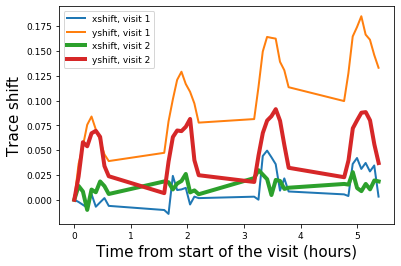

In [411]:
for visit, name, lw in [[visit1, 'visit 1', 2], [visit2, 'visit 2', 4]]:
    plt.plot((visit['times'] - visit['times'][0])*24, visit['xpos'] - visit['xpos'][0], label ='xshift, '+name, \
             lw = lw)
    plt.plot((visit['times'] - visit['times'][0])*24, visit['ypos'] - visit['ypos'][0], label ='yshift, '+name, \
             lw = lw)

plt.xlabel('Time from start of the visit (hours)', fontsize=15)
plt.ylabel('Trace shift',fontsize=15)
plt.legend()

And the fluxes:

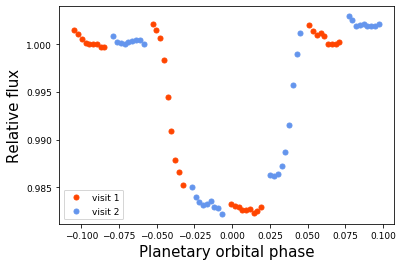

In [86]:
for visit, name, color in [[visit1, 'visit 1', 'orangered'], [visit2, 'visit 2', 'cornflowerblue']]:
    phases = juliet.utils.get_phases(visit['times'], P, t0)
    plt.plot(phases, visit['white-light'], 'o', label = name, \
             color = color)
plt.xlabel('Planetary orbital phase', fontsize=15)
plt.ylabel('Relative flux',fontsize=15)
plt.legend()

Another important regressor to add are the HST phases. HST has a period of `95.42` minutes --- so let's add that to each visit. Let's set the start of each visit as the zero-time:

In [87]:
HST_period = 95.42/(60. * 24.) # HST period in days
for visit in [visit1, visit2]:
    orbit_times = np.array(list(visit['orbits'].keys()))
    visit['orbital phase'] = juliet.utils.get_phases(visit['times'], HST_period, visit['times'][0])

Let's plot it:

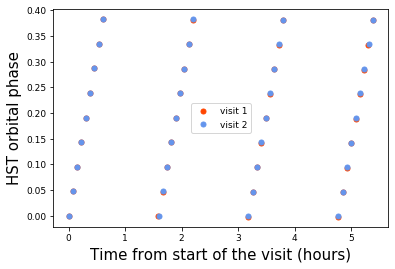

In [88]:
for visit, name, color in [[visit1, 'visit 1', 'orangered'], [visit2, 'visit 2', 'cornflowerblue']]:
    plt.plot((visit['times'] - visit['times'][0])*24, visit['orbital phase'], 'o', label = name, \
             color = color)
plt.xlabel('Time from start of the visit (hours)', fontsize=15)
plt.ylabel('HST orbital phase',fontsize=15)
plt.legend()

All right! Let's now run the white-light lightcurve fit with `juliet`. 

### 3.2 White-light lightcurve fit

#### 3.2.1 "Blind" white-light fit

We use the same model for the lightcurve fit as Evans et al. (2018) --- we use the centroids and orbital phase as regressors to dentrend the lightcurve. Let's define the dataset in the `juliet` format first. First-up, define the common priors to our model:

In [355]:
t0, P = 2456635.70832, 1.2749255

params = ['P_p1', 't0_p1', 'p_p1', 'b_p1', 'q1_visit1_visit2', 'q2_visit1_visit2', \
          'ecc_p1', 'omega_p1', 'a_p1']

dists = ['fixed', 'normal', 'uniform', 'uniform', 'uniform', 'uniform',\
          'fixed', 'fixed', 'uniform']

hyperps = [P, [t0, 0.1], [0., 0.5], [0., 0.5], [0., 1.], [0., 1.], \
          0., 90., [1., 10.]]

All right, now define the visit-dependant priors along with the data:

In [356]:
def std_regressor(x):
    return (x - np.mean(x))/np.sqrt(np.var(x))

t, f, ferr, GPregressors = {}, {}, {}, {}

for visit, name in [[visit1, 'visit1'], [visit2, 'visit2']]:
    
    # Ingest the fluxes:
    t[name] = visit['times']
    f[name] = visit['white-light']
    ferr[name] = visit['white-light errors']
    
    # Ingest regressors; make sure to normalize them:
    GPregressors[name] = np.vstack((std_regressor(visit['orbital phase']), \
                                   std_regressor(visit['xpos'])))
    
    GPregressors[name] = np.vstack((GPregressors[name], \
                                   std_regressor(visit['ypos']))).T
    
    # Define priors for those regressors; add an extra jitter term:
    params = params + ['sigma_w_'+name, 'GP_sigma_'+name, 'GP_alpha0_'+name, 'GP_alpha1_'+name, 'GP_alpha2_'+name, \
                       'mflux_'+name, 'mdilution_'+name]
    
    dists = dists + ['loguniform', 'loguniform', 'loguniform', 'loguniform', 'loguniform', \
                     'normal', 'fixed']
    
    hyperps = hyperps + [[1e-5, 1e3], [1e-5,1e3], [1e-5,1e3], [1e-5,1e3], [1e-5,1e3],\
                        [0., 0.1], 1.]

Lock the priors on a single dictionary:

In [357]:
priors = juliet.utils.generate_priors(params, dists, hyperps)

And run the fit!

In [358]:
dataset = juliet.load(priors=priors, t_lc = t, y_lc = f, yerr_lc = ferr, \
                      GP_regressors_lc = GPregressors, out_folder = 'white-light-fit')

results = dataset.fit(n_live_points = 500, verbose = True)

Detected multinest sampler output files --- extracting from white-light-fit/posteriors.pkl


What about fitting with the `catwoman` model?

In [359]:
params_cw = ['P_p1', 't0_p1', 'p1_p1', 'p2_p1', 'phi_p1', 'b_p1', 'q1_visit1_visit2', 'q2_visit1_visit2', \
          'ecc_p1', 'omega_p1', 'a_p1']

dists_cw = ['fixed', 'normal', 'uniform', 'uniform', 'fixed', 'uniform', 'uniform', 'uniform',\
          'fixed', 'fixed', 'uniform']

hyperps_cw = [P, [t0, 0.1], [0., 0.5], [0., 0.5], 90., [0., 0.5], [0., 1.], [0., 1.], \
             0., 90., [1., 10.]]

In [360]:
def std_regressor(x):
    return (x - np.mean(x))/np.sqrt(np.var(x))

t, f, ferr, GPregressors = {}, {}, {}, {}

for visit, name in [[visit1, 'visit1'], [visit2, 'visit2']]:
    
    # Ingest the fluxes:
    t[name] = visit['times']
    f[name] = visit['white-light']
    ferr[name] = visit['white-light errors']
    
    # Ingest regressors; make sure to normalize them:
    GPregressors[name] = np.vstack((std_regressor(visit['orbital phase']), \
                                   std_regressor(visit['xpos'])))
    
    GPregressors[name] = np.vstack((GPregressors[name], \
                                   std_regressor(visit['ypos']))).T
    
    # Define priors for those regressors; add an extra jitter term:
    params_cw = params_cw + ['sigma_w_'+name, 'GP_sigma_'+name, 'GP_alpha0_'+name, 'GP_alpha1_'+name, 'GP_alpha2_'+name, \
                       'mflux_'+name, 'mdilution_'+name]
    
    dists_cw = dists_cw + ['loguniform', 'loguniform', 'loguniform', 'loguniform', 'loguniform', \
                     'normal', 'fixed']
    
    hyperps_cw = hyperps_cw + [[1e-5, 1e3], [1e-5,1e3], [1e-5,1e3], [1e-5,1e3], [1e-5,1e3],\
                        [0., 0.1], 1.]

In [361]:
priors_cw = juliet.utils.generate_priors(params_cw, dists_cw, hyperps_cw)
print(priors_cw)

{'P_p1': {'distribution': 'fixed', 'hyperparameters': 1.2749255}, 't0_p1': {'distribution': 'normal', 'hyperparameters': [2456635.70832, 0.1]}, 'p1_p1': {'distribution': 'uniform', 'hyperparameters': [0.0, 0.5]}, 'p2_p1': {'distribution': 'uniform', 'hyperparameters': [0.0, 0.5]}, 'phi_p1': {'distribution': 'fixed', 'hyperparameters': 90.0}, 'b_p1': {'distribution': 'uniform', 'hyperparameters': [0.0, 0.5]}, 'q1_visit1_visit2': {'distribution': 'uniform', 'hyperparameters': [0.0, 1.0]}, 'q2_visit1_visit2': {'distribution': 'uniform', 'hyperparameters': [0.0, 1.0]}, 'ecc_p1': {'distribution': 'fixed', 'hyperparameters': 0.0}, 'omega_p1': {'distribution': 'fixed', 'hyperparameters': 90.0}, 'a_p1': {'distribution': 'uniform', 'hyperparameters': [1.0, 10.0]}, 'sigma_w_visit1': {'distribution': 'loguniform', 'hyperparameters': [1e-05, 1000.0]}, 'GP_sigma_visit1': {'distribution': 'loguniform', 'hyperparameters': [1e-05, 1000.0]}, 'GP_alpha0_visit1': {'distribution': 'loguniform', 'hyperpara

In [362]:
dataset_cw = juliet.load(priors=priors_cw, t_lc = t, y_lc = f, yerr_lc = ferr, \
                      GP_regressors_lc = GPregressors, out_folder = 'white-light-fit_cw')

results_cw = dataset_cw.fit(n_live_points = 500, verbose = True)

Detected multinest sampler output files --- extracting from white-light-fit_cw/posteriors.pkl


#### 3.2.2 White-light fit using TESS-retrieved properties

The above considered the planetary properties of WASP-121 as largely unknown. However, we have ran some TESS fits on the three sectors, and have already constrained those properties to an _excellent_ degree. Let's use those as priors to our fits. In addition, let's also fit for a linear trend in time to account for visit-long slopes.

One important caveat: the TESS time-of-transit center is in BJD TDB, and has an uncertainty of 3 seconds. However, the HST time-tags are in JD (UTC), and they only have an accuracy [good at the 1-second level](https://iopscience.iop.org/article/10.1086/655938/pdf). So we need to convert the latter ones. To this end, we use `barycorrpy`, [assuming that my thinking of how it works is OK for HST data](https://github.com/shbhuk/barycorrpy/issues/43). Because of the latter, we input a random location on the converter:

In [363]:
from astropy.time import Time
from barycorrpy import utc_tdb

for visit in [visit1, visit2]:
    JDUTC = Time(visit['times'], format='jd', scale='utc')
    visit['BJD_TBD_times'] = utc_tdb.JDUTC_to_BJDTDB(JDUTC, ra = 107.6002500, dec = -39.097380, \
                                                     lat=-30.169283, longi=-70.806789, alt=2241.9)[0]
    print((visit['BJD_TBD_times'] - visit['times'])*24*3600)

[79.77977246 79.79284823 79.805924   79.81895953 79.8320353  79.84511107
 79.85814661 79.87122238 79.88425791 80.05243242 80.06546795 80.07854372
 80.09161949 80.10465503 80.1177308  80.13080657 80.14388233 80.1569581
 80.32545447 80.33857048 80.35168648 80.36476225 80.37787825 80.39099425
 80.40415049 80.41726649 80.43038249 80.59984446 80.61304092 80.62619716
 80.63943386 80.65263033 80.6658268  80.67902327 80.69225997 80.70549667]
[132.85182416 132.8646183  132.87745267 132.89024681 132.90304095
 132.91583508 132.92862922 132.94142336 132.95421749 133.11840892
 133.13112259 133.14383626 133.1565097  133.16922337 133.18189681
 133.19461048 133.20728391 133.21995735 133.38290155 133.39553475
 133.40816796 133.42076093 133.43339413 133.44598711 133.45858008
 133.47121328 133.48380625 133.64606649 133.65861923 133.6712122
 133.68376493 133.69635791 133.70895088 133.72150362 133.73409659
 133.74664932]


In [415]:
print(visit1['BJD_TBD_times'][0])
print(visit2['BJD_TBD_times'][0])

2457686.114449157
2457698.897436697


The differences were super important! _Minutes_! Okay, let's add these times to the `juliet` data vector:

In [364]:
for visit, name in [[visit1, 'visit1'], [visit2, 'visit2']]:
    print('Old first time for '+name+':', t[name][0])
    t[name] = visit['BJD_TBD_times']
    print('New first time for '+name+':', t[name][0])

Old first time for visit1: 2457686.11352578
New first time for visit1: 2457686.114449157
Old first time for visit2: 2457698.89589906
New first time for visit2: 2457698.897436697


All right, conversion done and worked! Let's now re-define priors:

In [365]:
P_TESS, P_TESS_err = 1.2749250073, 0.0000001148
t0_TESS, t0_TESS_err = 2459253.1289134766, 0.0000375421

params = ['P_p1', 't0_p1', 'p_p1', 'b_p1', 'q1_visit1_visit2', 'q2_visit1_visit2', \
          'ecc_p1', 'omega_p1', 'a_p1']

dists = ['normal', 'normal', 'uniform', 'truncatednormal', 'uniform', 'uniform',\
          'fixed', 'fixed', 'normal']

hyperps = [[P_TESS, P_TESS_err], [t0_TESS, t0_TESS_err], [0., 0.5], [0.0927,0.056, 0., 1.], [0., 1.], [0., 1.], \
          0., 90., [3.808, 0.020]]

In [366]:
for visit, name in [[visit1, 'visit1'], [visit2, 'visit2']]:
    
    # Define priors for those regressors; add an extra jitter term:
    params = params + ['sigma_w_'+name, 'GP_sigma_'+name, 'GP_alpha0_'+name, 'GP_alpha1_'+name, 'GP_alpha2_'+name, \
                       'mflux_'+name, 'mdilution_'+name]
    
    dists = dists + ['loguniform', 'loguniform', 'loguniform', 'loguniform', 'loguniform', \
                     'normal', 'fixed']
    
    hyperps = hyperps + [[1e-5, 1e3], [1e-5,1e3], [1e-5,1e3], [1e-5,1e3], [1e-5,1e3],\
                        [0., 0.1], 1.]

In [367]:
priors = juliet.utils.generate_priors(params, dists, hyperps)

In [368]:
dataset = juliet.load(priors=priors, t_lc = t, y_lc = f, yerr_lc = ferr, \
                      GP_regressors_lc = GPregressors, out_folder = 'white-light-fit_TESSpriors')

results = dataset.fit(n_live_points = 500, verbose = True)

Detected multinest sampler output files --- extracting from white-light-fit_TESSpriors/posteriors.pkl


All right, let's run the same for `catwoman`:

In [369]:
params_cw = ['P_p1', 't0_p1', 'p1_p1', 'p2_p1', 'phi_p1', 'b_p1', 'q1_visit1_visit2', 'q2_visit1_visit2', \
          'ecc_p1', 'omega_p1', 'a_p1']

dists_cw = ['normal', 'normal', 'uniform', 'uniform', 'fixed', 'truncatednormal', 'uniform', 'uniform',\
          'fixed', 'fixed', 'normal']

hyperps_cw = [[P_TESS, P_TESS_err], [t0_TESS, t0_TESS_err], [0., 0.5], [0., 0.5], 90., [0.0927,0.056, 0., 1.], [0., 1.], [0., 1.], \
          0., 90., [3.808, 0.020]]

In [370]:
for visit, name in [[visit1, 'visit1'], [visit2, 'visit2']]:
    

    
    # Define priors for those regressors; add an extra jitter term:
    params_cw = params_cw + ['sigma_w_'+name, 'GP_sigma_'+name, 'GP_alpha0_'+name, 'GP_alpha1_'+name, 'GP_alpha2_'+name, \
                       'mflux_'+name, 'mdilution_'+name]
    
    dists_cw = dists_cw + ['loguniform', 'loguniform', 'loguniform', 'loguniform', 'loguniform', \
                     'normal', 'fixed']
    
    hyperps_cw = hyperps_cw + [[1e-5, 1e3], [1e-5,1e3], [1e-5,1e3], [1e-5,1e3], [1e-5,1e3],\
                        [0., 0.1], 1.]

In [371]:
priors_cw = juliet.utils.generate_priors(params_cw, dists_cw, hyperps_cw)
print(priors_cw)

{'P_p1': {'distribution': 'normal', 'hyperparameters': [1.2749250073, 1.148e-07]}, 't0_p1': {'distribution': 'normal', 'hyperparameters': [2459253.1289134766, 3.75421e-05]}, 'p1_p1': {'distribution': 'uniform', 'hyperparameters': [0.0, 0.5]}, 'p2_p1': {'distribution': 'uniform', 'hyperparameters': [0.0, 0.5]}, 'phi_p1': {'distribution': 'fixed', 'hyperparameters': 90.0}, 'b_p1': {'distribution': 'truncatednormal', 'hyperparameters': [0.0927, 0.056, 0.0, 1.0]}, 'q1_visit1_visit2': {'distribution': 'uniform', 'hyperparameters': [0.0, 1.0]}, 'q2_visit1_visit2': {'distribution': 'uniform', 'hyperparameters': [0.0, 1.0]}, 'ecc_p1': {'distribution': 'fixed', 'hyperparameters': 0.0}, 'omega_p1': {'distribution': 'fixed', 'hyperparameters': 90.0}, 'a_p1': {'distribution': 'normal', 'hyperparameters': [3.808, 0.02]}, 'sigma_w_visit1': {'distribution': 'loguniform', 'hyperparameters': [1e-05, 1000.0]}, 'GP_sigma_visit1': {'distribution': 'loguniform', 'hyperparameters': [1e-05, 1000.0]}, 'GP_alp

In [372]:
dataset_cw = juliet.load(priors=priors_cw, t_lc = t, y_lc = f, yerr_lc = ferr, \
                      GP_regressors_lc = GPregressors, out_folder = 'white-light-fit_TESSpriors_cw')

results_cw = dataset_cw.fit(n_live_points = 500, verbose = True)

Detected multinest sampler output files --- extracting from white-light-fit_TESSpriors_cw/posteriors.pkl


#### 3.2.2 White-light fit using TESS-retrieved properties + visit-long slope

One of the systematics I completely neglected above is the classic visit-long slope --- a simple line as a function of time that takes care of a typical visit-long slope seen on HST data. This might be why we see some extra jitter in the second visit. Let's also normalize that regressor:

In [373]:
LM_regressor = {}
for name in ['visit1', 'visit2']:
    
    LM_regressor[name] = np.zeros([len(t[name]), 1])
    LM_regressor[name][:,0] = std_regressor((t[name] - t[name][0]))
    #print(LM_regressor[name])
    #LM_regressor[name] = std_regressor((t[name] - t[name][0]))
    
print(LM_regressor)

{'visit1': array([[-1.50381856],
       [-1.46124325],
       [-1.41866297],
       [-1.37608766],
       [-1.33350738],
       [-1.29093206],
       [-1.24835166],
       [-1.20577635],
       [-1.16319607],
       [-0.61481382],
       [-0.57223851],
       [-0.5296581 ],
       [-0.48708279],
       [-0.44450251],
       [-0.4019272 ],
       [-0.35934692],
       [-0.3167716 ],
       [-0.27419133],
       [ 0.27419111],
       [ 0.3167714 ],
       [ 0.35934672],
       [ 0.401927  ],
       [ 0.44450232],
       [ 0.48708267],
       [ 0.52965807],
       [ 0.57223835],
       [ 0.61481367],
       [ 1.16319613],
       [ 1.20577649],
       [ 1.24835188],
       [ 1.29093219],
       [ 1.33350752],
       [ 1.37608782],
       [ 1.41866315],
       [ 1.46124345],
       [ 1.50381879]]), 'visit2': array([[-1.50372743],
       [-1.46116901],
       [-1.4186056 ],
       [-1.3760471 ],
       [-1.33348364],
       [-1.29092521],
       [-1.24836182],
       [-1.20580339],
       [-

All right, let's run the normal `batman` white-light fit again with the TESS priors but with this slope as a linear regressor as well. We need to add an extra set of hyperparameters to the fit to fit for this new regressor. We add it right away for both the `batman` model and the `catwoman` model:

In [374]:
for visit, name in [[visit1, 'visit1'], [visit2, 'visit2']]:
    
    # Define priors for the extra (linear) regressor:
    params = params + ['theta0_'+name]
    params_cw = params_cw + ['theta0_'+name]
    
    dists = dists + ['uniform']
    dists_cw = dists_cw + ['uniform']
    
    hyperps = hyperps + [[-10, 10]]
    hyperps_cw = hyperps_cw + [[-10, 10]]

In [375]:
priors = juliet.utils.generate_priors(params, dists, hyperps)

In [376]:
dataset = juliet.load(priors=priors, t_lc = t, y_lc = f, yerr_lc = ferr, \
                      GP_regressors_lc = GPregressors, linear_regressors_lc = LM_regressor, \
                      out_folder = 'white-light-fit_TESSpriors-VisitSlope')

results = dataset.fit(n_live_points = 500, verbose = True)

Detected multinest sampler output files --- extracting from white-light-fit_TESSpriors-VisitSlope/posteriors.pkl


And let's do the same, but running the `catwoman` model:

In [377]:
priors_cw = juliet.utils.generate_priors(params_cw, dists_cw, hyperps_cw)

In [378]:
dataset_cw = juliet.load(priors=priors_cw, t_lc = t, y_lc = f, yerr_lc = ferr, \
                      GP_regressors_lc = GPregressors, linear_regressors_lc = LM_regressor, \
                      out_folder = 'white-light-fit_TESSpriors-VisitSlope_cw')

results_cw = dataset_cw.fit(n_live_points = 500, verbose = True)

Detected multinest sampler output files --- extracting from white-light-fit_TESSpriors-VisitSlope_cw/posteriors.pkl


So --- which of the two models is preferred given the data?

In [401]:
print('Evidence for batman model:', results.posteriors['lnZ'])
print('Evidence for catwoman model:', results_cw.posteriors['lnZ'])
print('Difference (batman - catwoman):', results.posteriors['lnZ'] - results_cw.posteriors['lnZ'])

Evidence for batman model: 413.62599991850175
Evidence for catwoman model: 411.43650980716785
Difference (batman - catwoman): 2.189490111333896


So it seems both models are basically indistinguishable, with the `batman` model having a better (higher) evidence; we move forward with that model for the white-light model.

#### 3.2.3 Some plots

Let's plot the white-light lightcurves for the `batman` model. First, here's a function to plot a transit lightcurve (without the systematics models):

In [380]:
import batman
def batman_model(t):
    """
    Given a time array t, an inclination "inc" and a wavelength in microns "w", this function returns 
    a lightcurve model including limb-darkening.
    """
    params = batman.TransitParams()
    params.t0 = 2459253.1289434428 # time of inferior conjunction
    params.per = 1.2749246683 # orbital period (days)
    params.a = 3.8015362036 # semi-major axis (in units of stellar radii)
    params.rp = 0.1216532897
    params.inc = 88.91 # orbital inclination (in degrees)
    params.ecc = 0. # eccentricity
    params.w = 90. # longitude of periastron (in degrees) p
    params.limb_dark = 'quadratic' # limb darkening profile to use
    
    params.u = [0.4963421365573328,0.17008087302441927] # limb darkening coefficients

    tmodel = batman.TransitModel(params, t.astype('float64'))
    return tmodel.light_curve(params)

And now let's plot the systematics + model, the data, and then the data corrected for that systematics model:

dict_keys(['p1', 'lm', 'transit'])
dict_keys(['p1', 'lm', 'transit'])


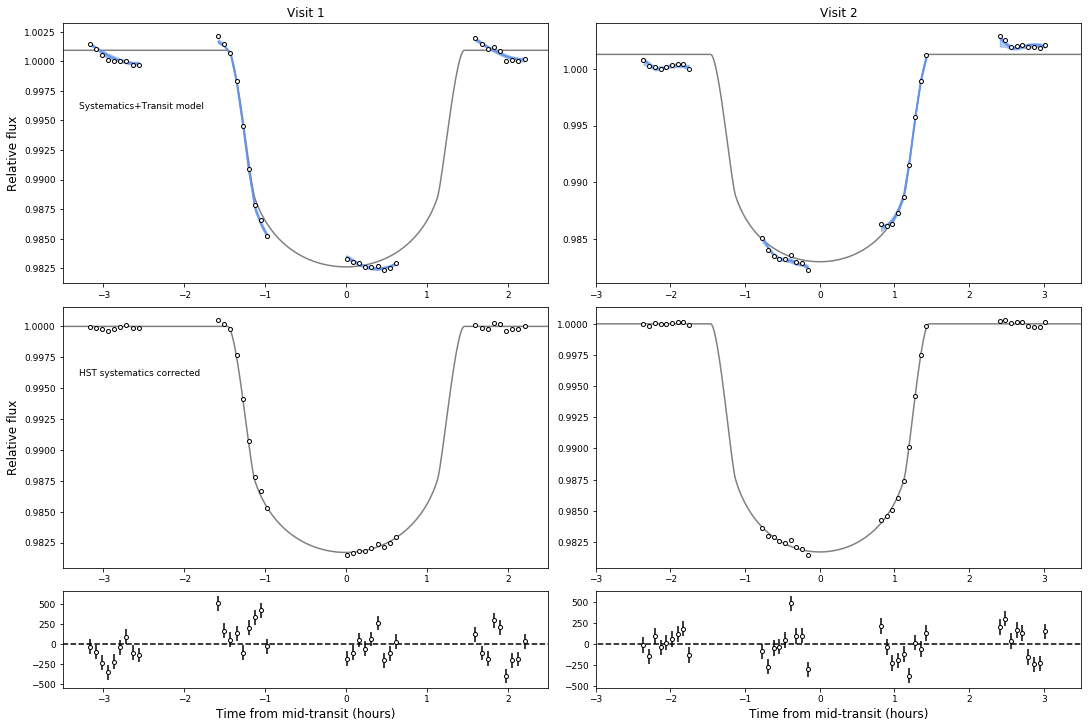

In [409]:
P, t0 = np.median(results.posteriors['posterior_samples']['P_p1']),\
        np.median(results.posteriors['posterior_samples']['t0_p1'])

fig = plt.figure(constrained_layout=True, figsize = (15,10))
gs = fig.add_gridspec(8, 8)

for visit_name in ['visit1', 'visit2']:
    
    if visit_name == 'visit1':
        transit_ax = fig.add_subplot(gs[0:3, 0:4])
        corrected_ax = fig.add_subplot(gs[3:6, 0:4])
        residuals_ax = fig.add_subplot(gs[6:, 0:4])
        
        corrected_ax.set_xlim(-3.5,2.5)
        transit_ax.set_xlim(-3.5,2.5)
        residuals_ax.set_xlim(-3.5,2.5)
        
        transit_ax.text(-3.3, 0.996, 'Systematics+Transit model')
        corrected_ax.text(-3.3, 0.996, 'HST systematics corrected')
        transit_ax.set_title('Visit 1', fontsize = 12)
        residuals_ax.set_xlabel('Time from mid-transit (hours)', fontsize = 12)
        transit_ax.set_ylabel('Relative flux', fontsize = 12)
        corrected_ax.set_ylabel('Relative flux', fontsize = 12)
    else:
        transit_ax = fig.add_subplot(gs[0:3, 4:])
        corrected_ax = fig.add_subplot(gs[3:6, 4:])
        residuals_ax = fig.add_subplot(gs[6:, 4:])
        
        corrected_ax.set_xlim(-3.,3.5)
        transit_ax.set_xlim(-3.,3.5)
        residuals_ax.set_xlim(-3.,3.5)
        transit_ax.set_title('Visit 2', fontsize = 12)
        residuals_ax.set_xlabel('Time from mid-transit (hours)', fontsize = 12)
        
    # Plot data:
    tt, ff, fferr = dataset.times_lc[visit_name], dataset.data_lc[visit_name], np.copy(dataset.errors_lc[visit_name])
    phases = juliet.utils.get_phases(tt, P, t0) * P * 24
    
    sigma_w = np.median(results.posteriors['posterior_samples']['sigma_w_'+visit_name])
    ferr = np.sqrt(fferr**2 + (sigma_w*1e-6)**2)
    
    transit_ax.errorbar(phases, ff, fferr, fmt = 'o', zorder = 3, ms = 4, mfc = 'white', \
                        mec = 'black', ecolor = 'black')
    
    # Model eval and results:
    full_model, error68_up, error68_down, components = results.lc.evaluate(visit_name, \
                                                                          return_err=True, \
                                                                          return_components = True)
    
    full_model, error95_up, error95_down, components = results.lc.evaluate(visit_name, \
                                                                          return_err=True, \
                                                                          return_components = True, \
                                                                          alpha = 0.95)
    
    print(components.keys())
    # Evaluate the transit only:
    tfake = np.linspace(np.min(tt)-0.2, np.max(tt)+0.2, 1000)
    pfake = juliet.utils.get_phases(tfake, P, t0) * P * 24
    # Multiply by mflux:
    mflux = results.posteriors['posterior_samples']['mflux_'+visit_name]
    transit_model = batman_model(tfake) * (1. / (1. + np.median(mflux)))
    
    # Cut dataset per orbit:
    phase_diffs = np.diff(phases)
    phase_breaks = np.where(phase_diffs>0.5)[0]
    phase_breaks = np.append(phase_breaks, len(phases)-1)
    c_break = 0
    for phase_break in phase_breaks:
        idx = np.arange(c_break, phase_break+1)
        if c_break == 0:
            transit_ax.plot(phases[idx], full_model[idx], color = 'cornflowerblue', zorder = 2, label = '')
        else:
            transit_ax.plot(phases[idx], full_model[idx], color = 'cornflowerblue', zorder = 2)
        transit_ax.fill_between(phases[idx], error68_down[idx], error68_up[idx], \
                                color = 'cornflowerblue', alpha = 0.5, zorder = 0)
        transit_ax.fill_between(phases[idx], error95_down[idx], error95_up[idx], \
                                color = 'cornflowerblue', alpha = 0.5, zorder = 1)
        c_break = phase_break+1
        
    # Plot transit:
    transit_ax.plot(pfake, transit_model, color='grey', zorder = 0)
    
    # Plot corrected lightcurve:
    corrected_ax.errorbar(phases, (ff - (full_model - components['transit'])), fferr, fmt = 'o', zorder = 3, ms = 4, mfc = 'white', \
                          mec = 'black', ecolor = 'black')
    
    corrected_ax.plot(pfake, batman_model(tfake), color='grey', zorder = 0)
    
    # Plot residuals:
    residuals_ax.errorbar(phases, (ff - full_model)*1e6 , fferr*1e6, fmt = 'o', zorder = 3, ms = 4, mfc = 'white', \
                          mec = 'black', ecolor = 'black')
    
    residuals_ax.plot([-10,10], [0,0] , 'k--')
#plt.savefig('hst_magic.pdf')